In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import iris


In [ ]:
# This notebook is a combination of code from Laura Gibbs and Timothy Andrews

SUITE_DICT = {
    'cy837': ['1.5K', 'blue'], 
    'cy838': ['2.0K', 'green'], 
    'cz374': ['2.5K', 'gold'], 
    'cz375': ['3.0K', 'orange'], 
    'cz376': ['4.0K', 'orangered'], 
    'cz377': ['5.0K', 'crimson'], 
    'cz378': ['6.0K', 'darkred'],
}

RAMP_DICT = {
    'cx209': ['8GtC/Yr', 'black'],
    'cw988': ['8GtC/Yr', 'black'],
    'cw989': ['8GtC/Yr', 'black'],
}
ALL_DICT = RAMP_DICT | SUITE_DICT

suites = list(SUITE_DICT.keys())
ramp_suites = list(RAMP_DICT.keys())
all_suites = ramp_suites + suites

suite_legend = {}
for suite, (suite, color) in ALL_DICT.items():
    if suite not in suite_legend:
        suite_legend[suite] = color
legend_handles = []

for suite, color in suite_legend.items():
    legend_handles.append(plt.Line2D([], [], color=color, linestyle='-', label=suite))

In [ ]:
ze_data_dir = "/path/to/data/"
suite_paths = [f'{ze_data_dir}{name}_global.nc' for name in suites]
ramp_suite_paths = [f'{ze_data_dir}{name}_global.nc' for name in ramp_suites]
all_suite_paths = ramp_suite_paths + suite_paths

In [ ]:
# Load in the AOGCM data to compare against 
ramp_ts = []
ramp_co2s = []
for path in ramp_suite_paths:
    ramp_ts.append(iris.load_cube(path, 'tas_glb_mean'))
    ramp_co2s.append(iris.load_cube(path, 'co2GtC_glb_mean'))
    
toas = []
co2s = []
ts = []
for path in suite_paths:
    toas.append(iris.load_cube(path, 'toa_glb_mean'))
    co2s.append(iris.load_cube(path, 'co2GtC_glb_mean'))
    ts.append(iris.load_cube(path, 'tas_glb_mean'))

# CO2_ref as mean of first year of ramps
co2_ref=(ramp_co2s[0].data[0]+ramp_co2s[1].data[0]+ramp_co2s[2].data[0])/3

ERFs=co2s.copy()
for i in range(len(co2s)):
 for j in range(len(co2s[i].data)):
  ERFs[i].data[j] = 5.77 * np.log(co2s[i].data[j] / co2_ref)

ramp_ERFs=ramp_co2s.copy()
for i in range(len(ramp_co2s)):
 for j in range(len(ramp_co2s[i].data)):
  ramp_ERFs[i].data[j] = 5.77 * np.log(ramp_co2s[i].data[j] / co2_ref)



In [49]:
def twolayermodel(timeyears, forcing, lambda_0, gamma, C_ml, C_deep, efficacy, T_ml0=0.0, T_deep0=0.0):

    result = {}

    # Time-stepping parameters:
    dt = 60.*60.*24.*365. # time-step of one year in seconds
    nstep      = np.size(timeyears) # number of time-steps = numbers of years

    # Initialize state variables:
    T_ml       = np.zeros(nstep)
    T_deep     = np.zeros(nstep)
    T_ml[0]    = T_ml0
    T_deep[0]  = T_deep0
    imbalance  = np.zeros(nstep)
    
    # Integrate:
    imbalance[0] = np.nan 
    for t in range(0, nstep-1):
        T_ml[t+1]      = T_ml[t] + (forcing[t]+lambda_0*T_ml[t]-efficacy*gamma*(T_ml[t]-T_deep[t]))*dt/C_ml
        T_deep[t+1]    = T_deep[t] + gamma*(T_ml[t]-T_deep[t])*dt/C_deep
        imbalance[t+1] = (C_ml*(T_ml[t+1]-T_ml[t]) + C_deep*(T_deep[t+1]-T_deep[t]))/dt
    
    # Output result and settings for this run:
    result['time'] = timeyears
    result['forcing'] = forcing
    result['T_ml'] = T_ml
    result['T_deep'] = T_deep
    result['imbalance'] = imbalance

    result['C_ml'] = C_ml
    result['C_deep'] = C_deep
    result['gamma'] = gamma
    result['lambda_0'] = lambda_0
    result['efficacy'] = efficacy
        
    return result


In [50]:
# Define values for two layer model calibrated to UKESM1.0-LL
# Values taken from Armour et al. (2024; https://doi.org/10.1073/pnas.2312093121)
# Supplementary Information, Table S2

nsecs_per_year = 60*60*24*365
C_ml    = 8.0 * nsecs_per_year # convert from W yr/m2/K to J/m2/K
C_deep  = 80 * nsecs_per_year # convert from W yr/m2/K to J/m2/K
gamma   = 0.52 # W/m2/K
efficacy = 1.13 # unitless
lambda_0 = -0.67 # W/m2/K

In [51]:
# Run the two layer model over the 6 different scenarios

dyrs = []
dFs = []
dNs = []
dTs = []
dT0s = []

for i in range(1, 8):
    dF = np.load(f'EBM_files/dF{i}.npy')
    dFs.append(dF)
    timeyears = np.load(f'EBM_files/yr{i}.npy')
    experiment = twolayermodel(timeyears, dF, lambda_0, gamma, C_ml, C_deep, efficacy)
    dyrs.append(experiment['time'])
    dTs.append(experiment['T_ml'])
    dNs.append(experiment['imbalance'])
    dT0s.append(experiment['T_deep'])


branch_dates = [1919,1944,1970,1992,2044,2082,2137]


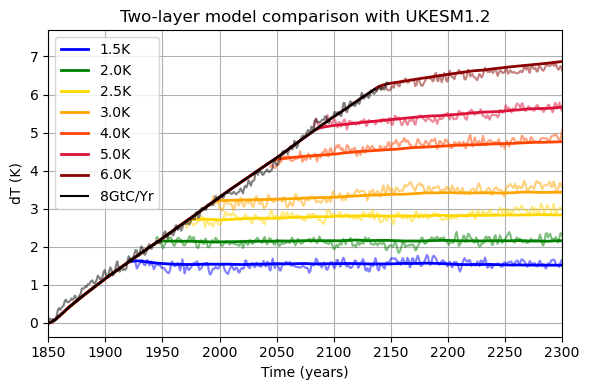

In [52]:
# Calculate T ref as mean of 1st year of ramp
T_ref=(ramp_ts[0].data[0]+ramp_ts[1].data[0]+ramp_ts[2].data[0])/3

window_size = 2

fig, ax = plt.subplots(figsize=(6,4.))
for suite, yr, dT, t in zip(suites, dyrs, dTs, ts):
    roll_t = np.convolve(t.data[0:-1]-T_ref, np.ones(window_size)/window_size, mode='valid')
    roll_yr = np.convolve(t.coord('year').points[0:-1], np.ones(window_size)/window_size, mode='valid')
    
    ax.plot(yr, dT, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1],linewidth=2)
    ax.plot(roll_yr, roll_t, color=SUITE_DICT[suite][1], alpha=0.5)
ax.plot(yr[:-1][:(branch_dates[-1]-1850)], dT[:-1][:(branch_dates[-1]-1850)], color='black', label='8GtC/Yr')
roll_ramp_t = np.convolve(ramp_ts[0].data[0:-90]-T_ref, np.ones(window_size)/window_size, mode='valid')
roll_ramp_yr = np.convolve(ramp_ts[0].coord('year').points[0:-90], np.ones(window_size)/window_size, mode='valid')
ax.plot(roll_ramp_yr, roll_ramp_t,  color='black', alpha=0.5)

ax.set_xlim(1850,2300)
ax.grid()
plt.xlabel('Time (years)')
plt.ylabel('dT (K)')
plt.title('Two-layer model comparison with UKESM1.2')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Now do constant F : emulating committed warming
dFs_const = []
yrs_const = []
dTs_const = []
dNs_const = []
for i in range(1, 8):
    dF = np.load(f'EBM_files/dF{i}_const.npy')
    timeyears = np.load(f'EBM_files/yr{i}_const.npy')
    experiment = twolayermodel(timeyears, dF, lambda_0, gamma, C_ml, C_deep, efficacy)
    yrs_const.append(experiment['time'])
    dTs_const.append(experiment['T_ml'])
    dNs_const.append(experiment['imbalance'])
    dFs_const.append(dF)

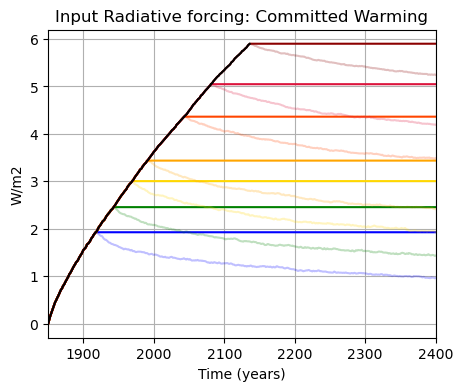

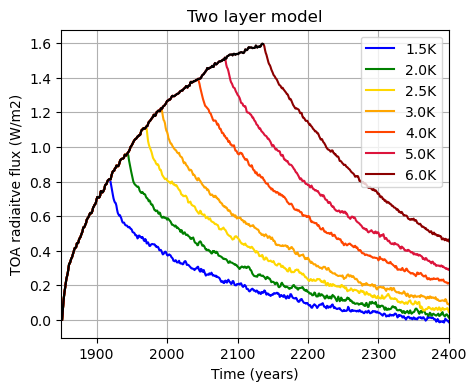

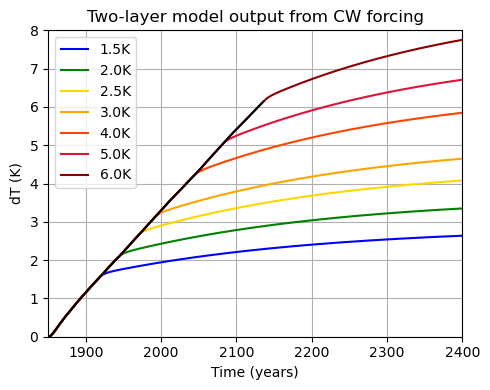

In [54]:
fig1, ax = plt.subplots(figsize=(5,4))
for suite, yr, dF, yr_const, dF_const in zip(suites, dyrs, dFs, yrs_const, dFs_const):
    ax.plot(yr, dF, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1], alpha=0.25)
    ax.plot(yr_const, dF_const, color=SUITE_DICT[suite][1])
ax.plot(yr[:-1][:(branch_dates[-1]-1850)], dF[:-1][:(branch_dates[-1]-1850)], color='black')
ax.set_xlim(1850,2400)
ax.grid()
plt.xlabel('Time (years)')
plt.ylabel('W/m2')
plt.title('Input Radiative forcing: Committed Warming')

fig2, ax = plt.subplots(figsize=(5,4))
for suite, yr, dN, yr_const, dN_const in zip(suites, dyrs, dNs, yrs_const, dNs_const):
    ax.plot(yr, dN, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1])
    # ax.plot(yr_const, dN_const, color=SUITE_DICT[suite][1], alpha=0.25)
ax.plot(yr[:-1][:(branch_dates[-1]-1850)], dN[:-1][:(branch_dates[-1]-1850)], color='black')
ax.grid()
ax.set_xlim(1850,2400)
plt.xlabel('Time (years)')
plt.ylabel('TOA radiaitve flux (W/m2)')
plt.title('Two layer model')
plt.legend()

fig, ax = plt.subplots(figsize=(5,4))
for suite, branch_date, yr, dT in zip(suites, branch_dates, yrs_const, dTs_const):
    ax.plot(yr, dT, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1])

ax.plot(yr[:-1][:(branch_dates[-1]-1850)], dT[:-1][:(branch_dates[-1]-1850)], color='black')
ax.set_xlim(1850, 2400)
ax.set_ylim(0, 8)
plt.xlabel('Time (years)')
plt.ylabel('dT (K)')
plt.title(f'Two-layer model output from CW forcing')
ax.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
# Inputting the CC part for just after the point of ZE
# Run the two layer model over the 6 different scenarios

dFs_CC_ZE_only = []
yrs_CC_ZE_only = []
dTs_CC_ZE_only = []
dNs_CC_ZE_only = []

for i in range(1, 8):
    dF = np.load(f'EBM_files/dF{i}_CC_ZE_only.npy')
    timeyears = np.load(f'EBM_files/yr{i}_CC_ZE_only.npy')
    experiment = twolayermodel(timeyears, dF, lambda_0, gamma, C_ml, C_deep, efficacy)
    yrs_CC_ZE_only.append(experiment['time'])
    dTs_CC_ZE_only.append(experiment['T_ml'])
    dNs_CC_ZE_only.append(experiment['imbalance'])
    dFs_CC_ZE_only.append(dF)

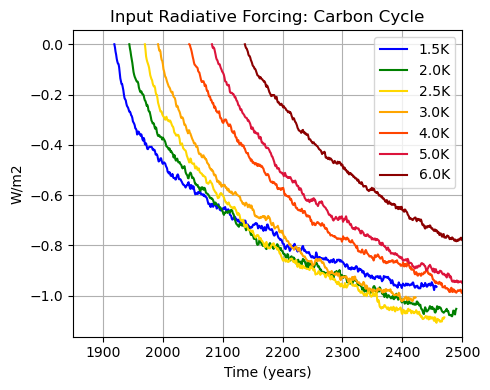

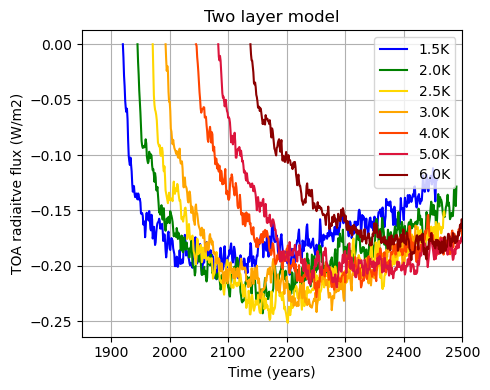

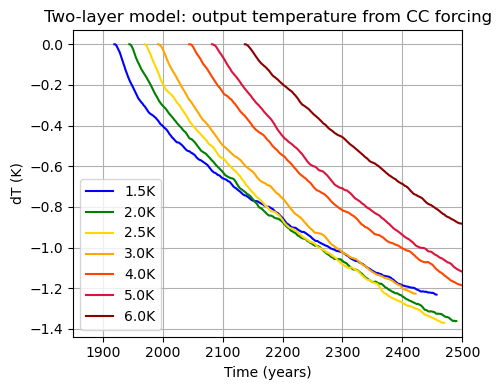

In [56]:
fig1, ax = plt.subplots(figsize=(5,4))
for suite, yr, dF in zip(suites, yrs_CC_ZE_only, dFs_CC_ZE_only):
    ax.plot(yr, dF, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1])
ax.set_xlim(1850,2500)
plt.xlabel('Time (years)')
plt.ylabel('W/m2')
plt.title('Input Radiative Forcing: Carbon Cycle')
plt.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig2, ax = plt.subplots(figsize=(5,4))
for suite, yr, dN in zip(suites, yrs_CC_ZE_only, dNs_CC_ZE_only):
    ax.plot(yr, dN, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1])
ax.grid()
ax.set_xlim(1850,2500)
plt.xlabel('Time (years)')
plt.ylabel('TOA radiaitve flux (W/m2)')
plt.title('Two layer model')
plt.legend()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(5, 4))
for suite, branch_date, yr, dT in zip(suites, branch_dates, yrs_CC_ZE_only, dTs_CC_ZE_only):
    # Calculate the dT change between the branch dates and  later
    ax.plot(yr, dT, label=SUITE_DICT[suite][0], color=SUITE_DICT[suite][1])
ax.set_xlim(1850,2500)
ax.grid()
plt.xlabel('Time (years)')
plt.ylabel('dT (K)')
plt.title(f'Two-layer model: output temperature from CC forcing')
plt.legend()
plt.tight_layout()
plt.show()
